In [30]:
import h5py
import numpy as np
import pandas as pd

with h5py.File('RespCoupling.Mat', 'r') as file:
    # Extract the data matrix
    data_matrix = np.array(file['fArray'])
    
    # Extract the feature names
    feature_names = []
    for ref in file['fNames']:
        # Dereference the object reference
        name_data = file[ref[0]]
        # Convert the uint16 array to a string
        name = ''.join(chr(i[0]) for i in name_data[:])
        feature_names.append(name)

# Create a DataFrame
resp_df = pd.DataFrame(data_matrix.T, columns=feature_names)

# Display the first few rows and info of the DataFrame
print(resp_df.head())
print("\
DataFrame Info:")
resp_df.info()

# Save the DataFrame to a CSV file
csv_filename = 'RespCoupling.csv'
resp_df.to_csv(csv_filename, index=False)
print(f"\
Data saved to {csv_filename}")

print("Done")



/var/folders/p1/vychbyg51cs0s16tvzh88pk00000gn/T/ipykernel_51404/3769664040.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data_matrix = np.array(file['fArray'])


    SN  Label  breathNumber  taskOrder  loadOrderCT  timeOfBreath   Age  Sex  \
0  3.0    1.0           2.0        2.0          1.0      3.527500  27.0  0.0   
1  3.0    1.0           3.0        2.0          1.0      6.355000  27.0  0.0   
2  3.0    1.0           4.0        2.0          1.0      9.388333  27.0  0.0   
3  3.0    1.0           5.0        2.0          1.0     13.041667  27.0  0.0   
4  3.0    1.0           6.0        2.0          1.0     16.673333  27.0  0.0   

   Height  Weight  ...  lagCoef_{0.50}  lagCoef_{0.75}     % RCi  TP_{RC,0}  \
0   158.0    52.9  ...       -0.216789       -0.160364  0.668837   0.541774   
1   158.0    52.9  ...       -0.274332       -0.205534  0.724171   0.000000   
2   158.0    52.9  ...       -0.302754       -0.206114  0.753504   0.512530   
3   158.0    52.9  ...        0.086828        0.031575  0.438083   0.488389   
4   158.0    52.9  ...        0.102044        0.044175  0.465689   0.143559   

    TP_{AB,0}   TP_{RC,0.10}  TP_{AB,0.10}  

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data

df = pd.read_csv('RespCoupling.csv')

# 1. Basic information about the dataset
print("1. Basic Information about the Dataset:")
print(df.info())

# 2. Summary statistics
print("\n2. Summary Statistics:")
print(df.describe())

# 3. Check for missing values
print("\n3. Missing Values:")
print(df.isnull().sum())

#replace column names
df.columns = df.columns.str.replace('\
abla ', 'del_', regex=True)
df.columns = df.columns.str.replace('\t', '', regex=True)
df.columns = df.columns.str.replace("\\n", '')
df.columns = df.columns.str.strip()

print("Column names have been updated.")
print("\
Updated column names:")
print(df.columns.tolist())

print("Done")

df['Nicottine Use'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Define a function to remove outliers using the IQR method with adjustable factors
def remove_outliers_iqr(df, column, lower_factor=1.5, upper_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - lower_factor * IQR
    upper_bound = Q3 + upper_factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the IQR method to columns with extreme ranges
columns_to_clean = ['work', 'PTP', 'workPerLiter']

# Store the original shape
original_shape = df.shape[0]

# Remove outliers for each specified column
for column in columns_to_clean:
    df = remove_outliers_iqr(df, column)

# Display the new shape and percentage of data retained
print(f"Original dataset shape: {original_shape}")
print(f"Cleaned dataset shape: {df.shape[0]}")
print(f"Percentage of data retained: {df.shape[0] / original_shape * 100:.2f}%")

# Save the cleaned dataset to a new CSV file
cleaned_file_name = 'RespCoupling_cleaned_v2.csv'
df.to_csv(cleaned_file_name, index=False)
print(f"Cleaned dataset saved as '{cleaned_file_name}'")

# 4. Distribution of 'work' variable
plt.figure(figsize=(10, 6))
sns.histplot(df['work'], kde=True)
plt.title('Distribution of Work of Breathing')
plt.xlabel('Work')
plt.savefig('work_distribution.png')
plt.close()

# 5. Box plot of 'work' for each Label
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='work', data=df)
plt.title('Work of Breathing by Label')
plt.savefig('work_by_label_boxplot.png')
plt.close()

# 6. Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()

# 7. Pairplot of key variables
key_vars = ['work', 'PTP', 'workPerLiter', 'Volume', 'T_i']
sns.pairplot(df[key_vars], diag_kind='kde')
plt.suptitle('Pairplot of Key Variables', y=1.02)
plt.savefig('key_variables_pairplot.png')
plt.close()

# 8. Time series plot of work for each label
plt.figure(figsize=(12, 6))
for label in df['Label'].unique():
    subset = df[df['Label'] == label]
    plt.plot(subset['timeOfBreath'], subset['work'], label=f'Label {label}')
plt.title('Work Over Time for Different Labels')
plt.xlabel('Time of Breath')
plt.ylabel('Work')
plt.legend()
plt.savefig('work_over_time.png')
plt.close()

# 9. Additional statistics
print("\n9. Unique values in 'Label' column:")
print(df['Label'].value_counts())

print("\n10. Correlation of 'work' with other variables:")
work_corr = df.corr()['work'].sort_values(ascending=False)
print(work_corr)

print("\nAll plots have been generated and saved.")

1. Basic Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9961 entries, 0 to 9960
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SN                       9961 non-null   float64
 1   Label                    9961 non-null   float64
 2   breathNumber             9961 non-null   float64
 3   taskOrder                9961 non-null   float64
 4   loadOrderCT              9961 non-null   float64
 5   timeOfBreath             9961 non-null   float64
 6   Age                      9961 non-null   float64
 7   Sex                      9961 non-null   float64
 8   Height                   9961 non-null   float64
 9   Weight                   9961 non-null   float64
 10  BMI                      9961 non-null   float64
 11  Body fat                 9961 non-null   float64
 12  Visceral fat             9961 non-null   float64
 13  Muscle                   9961 non-null

/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/p1/vychbyg51cs0s16tvzh88pk00000gn/T/ipykernel_51404/1980402164.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Nicottine Use'].replace

Cleaned dataset saved as 'RespCoupling_cleaned_v2.csv'

9. Unique values in 'Label' column:
Label
2.0    2034
1.0    1982
4.0    1192
3.0    1180
5.0    1150
6.0    1130
Name: count, dtype: int64

10. Correlation of 'work' with other variables:
work                   1.000000
PTP                    0.879341
workPerLiter           0.859728
Volume                 0.382438
Label                  0.369402
C_{flow,RC}            0.349865
C_{flow,AB}            0.333556
T_i                    0.284254
MSSE_{flow}            0.209631
timeOfBreath           0.159046
breathNumber           0.142545
BMI                    0.098391
Visceral fat           0.098096
Body fat               0.092901
lagCoef_{0.25}         0.075643
% RCi                  0.073261
VR_{RC}                0.072690
loadOrderCT            0.063808
Waist Size             0.057996
Chest Circunference    0.057401
Age                    0.049693
lagCoef_{0.50}         0.049324
C_{del_RC,del_AB}      0.047335
Weight             

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

# Load the cleaned dataset
df = pd.read_csv('RespCoupling_cleaned_v2.csv')

# Separate features and target variables
X = df.drop(['work', 'PTP', 'workPerLiter'], axis=1)
y_work = df['work']
y_ptp = df['PTP']
y_workPerLiter = df['workPerLiter']

# Handle non-numeric columns
X = pd.get_dummies(X, drop_first=True)

print("Data loaded and preprocessed.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y_work: {y_work.shape}")

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data after imputation
X_train, X_test, y_work_train, y_work_test = train_test_split(X_imputed, y_work, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LASSO Feature Selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_work_train)
lasso_selector = SelectFromModel(lasso, prefit=True)
lasso_features = X.columns[lasso_selector.get_support()].tolist()

print("LASSO selected features:")
print(lasso_features)

# Random Forest Feature Selection
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_work_train)
rf_selector = SelectFromModel(rf, prefit=True)
rf_features = X.columns[rf_selector.get_support()].tolist()

print("\
Random Forest selected features:")
print(rf_features)

# Combine features from both methods
combined_features = list(set(lasso_features + rf_features))
print("\
Combined selected features:")
print(combined_features)

# Save the list of selected features
with open('selected_features.txt', 'w') as f:
    for feature in combined_features:
        f.write(f"{feature}\
")

print("\
Selected features saved to 'selected_features.txt'")

Data loaded and preprocessed.
Shape of X: (8668, 40)
Shape of y_work: (8668,)
LASSO selected features:
['SN', 'Label', 'breathNumber', 'taskOrder', 'loadOrderCT', 'timeOfBreath', 'Height', 'BMI', 'Muscle', 'Chest Circunference', 'Nicottine Use', 'C_{flow,AB}', 'C_{RC,AB}', 'C_{flow,del_RC}', 'C_{del_RC,del_AB}', 'MSSE_{flow}', 'MSSE_{RC}', 'MSSE_{AB}', 'VR_{AB}', 'T_i', 'Volume', 'lagCoef_{0.25}', '% RCi']
Random Forest selected features:
['SN', 'Label', 'timeOfBreath', 'Volume']
Combined selected features:
['lagCoef_{0.25}', 'Height', '% RCi', 'MSSE_{AB}', 'C_{RC,AB}', 'MSSE_{RC}', 'Nicottine Use', 'C_{flow,AB}', 'Chest Circunference', 'Volume', 'Muscle', 'MSSE_{flow}', 'C_{del_RC,del_AB}', 'breathNumber', 'SN', 'taskOrder', 'C_{flow,del_RC}', 'T_i', 'Label', 'loadOrderCT', 'BMI', 'timeOfBreath', 'VR_{AB}']
Selected features saved to 'selected_features.txt'


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Use the combined selected features for regression
X_selected = df[combined_features]

# Impute missing values and scale the features
X_selected_imputed = imputer.fit_transform(X_selected)
X_train_sel, X_test_sel, y_work_train, y_work_test = train_test_split(X_selected_imputed, y_work, test_size=0.2, random_state=42)
X_train_sel_scaled = scaler.fit_transform(X_train_sel)
X_test_sel_scaled = scaler.transform(X_test_sel)

# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_sel_scaled, y_work_train)

# Predictions
y_work_pred = lin_reg.predict(X_test_sel_scaled)

# Evaluation
mse = mean_squared_error(y_work_test, y_work_pred)
r2 = r2_score(y_work_test, y_work_pred)

print("Linear Regression Model for WoB Prediction:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Save the model evaluation results
with open('regression_model_evaluation.txt', 'w') as f:
    f.write(f"Mean Squared Error: {mse:.2f}\
")
    f.write(f"R-squared: {r2:.2f}\
")

print("\
Regression model evaluation results saved to 'regression_model_evaluation.txt'")

Linear Regression Model for WoB Prediction:
Mean Squared Error: 17.34
R-squared: 0.57
Regression model evaluation results saved to 'regression_model_evaluation.txt'


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the data
df = pd.read_csv('RespCoupling_cleaned_v2.csv')

# Select relevant features based on our previous analysis
relevant_features = ['Volume', 'C_{flow,RC}', 'C_{flow,AB}', 'T_i', 'MSSE_{flow}', 'PTP']
target = 'work'

# Create X (features) and y (target)
X = df[relevant_features]
y = df[target]

# Check for missing values
print("Missing values in features:")
print(X.isnull().sum())
print("\
Missing values in target:")
print(y.isnull().sum())

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print("\
Preprocessed data shape:")
print(X_scaled.shape)
print("\
First few rows of preprocessed data:")
print(X_scaled.head())

# Save preprocessed data for the next step
X_scaled.to_csv('preprocessed_features.csv', index=False)
y.to_csv('target.csv', index=False)

print("\
Preprocessed data saved to CSV files.")
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the preprocessed data
X = pd.read_csv('preprocessed_features.csv')
y = pd.read_csv('target.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\
Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\
Feature Importance:")
print(feature_importance)

# Save the model
import joblib
joblib.dump(rf_model, 'random_forest_model.joblib')
print("\
Model saved as 'random_forest_model.joblib'")

Missing values in features:
Volume         0
C_{flow,RC}    0
C_{flow,AB}    0
T_i            0
MSSE_{flow}    0
PTP            0
dtype: int64
Missing values in target:
0
Preprocessed data shape:
(8668, 6)
First few rows of preprocessed data:
     Volume  C_{flow,RC}  C_{flow,AB}       T_i  MSSE_{flow}       PTP
0  0.461714    -0.959183    -1.127045 -1.050843    -0.526167 -0.505651
1 -0.141695    -1.218966    -0.972418 -0.592097    -0.730342 -0.623789
2 -0.073162    -2.125094    -1.319957 -0.940161    -0.813281 -0.612268
3 -0.011014    -0.731342     0.019387 -0.734818    -0.274581 -0.629317
4 -0.387095     0.019335     0.989623 -0.073642     0.828747 -0.538367
Preprocessed data saved to CSV files.
Training set shape: (6934, 6)
Testing set shape: (1734, 6)
Model Performance:
Mean Squared Error: 0.7734
Root Mean Squared Error: 0.8794
R-squared: 0.9810
Feature Importance:
       feature  importance
5          PTP    0.762977
0       Volume    0.164708
3          T_i    0.057537
2  C_{flow

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Train a Gradient Boosting Regressor
print("Training Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Calculate performance metrics for Gradient Boosting
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("\
Gradient Boosting Model Performance:")
print(f"Mean Squared Error: {mse_gb:.4f}")
print(f"Root Mean Squared Error: {rmse_gb:.4f}")
print(f"R-squared: {r2_gb:.4f}")

# Save the Gradient Boosting model
joblib.dump(gb_model, 'gradient_boosting_model.joblib')
print("\
Gradient Boosting model saved as 'gradient_boosting_model.joblib'")

Training Gradient Boosting Regressor...
Gradient Boosting Model Performance:
Mean Squared Error: 0.9929
Root Mean Squared Error: 0.9965
R-squared: 0.9756
Gradient Boosting model saved as 'gradient_boosting_model.joblib'


In [36]:
# Train a Neural Network Regressor
print("Training Neural Network Regressor...")
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred_mlp = mlp_model.predict(X_test)

# Calculate performance metrics for Neural Network
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("\
Neural Network Model Performance:")
print(f"Mean Squared Error: {mse_mlp:.4f}")
print(f"Root Mean Squared Error: {rmse_mlp:.4f}")
print(f"R-squared: {r2_mlp:.4f}")

# Save the Neural Network model
joblib.dump(mlp_model, 'neural_network_model.joblib')
print("\
Neural Network model saved as 'neural_network_model.joblib'")

Training Neural Network Regressor...
Neural Network Model Performance:
Mean Squared Error: 0.3810
Root Mean Squared Error: 0.6172
R-squared: 0.9906
Neural Network model saved as 'neural_network_model.joblib'


In [37]:
import matplotlib.pyplot as plt

# Plot breath-by-breath changes in Work of Breathing
plt.figure(figsize=(14, 6))
plt.plot(df['timeOfBreath'], df['work'], marker='o', linestyle='-', markersize=3)
plt.title('Breath-by-Breath Changes in Work of Breathing')
plt.xlabel('Time of Breath')
plt.ylabel('Work of Breathing')
plt.grid(True)
plt.tight_layout()
plt.savefig('breath_by_breath_wob.png')
plt.close()

print("Breath-by-breath changes in Work of Breathing plotted and saved as 'breath_by_breath_wob.png'.")

# Calculate rolling mean to smooth the data and observe trends
rolling_window = 50  # Adjust the window size as needed

df['rolling_work'] = df['work'].rolling(window=rolling_window, min_periods=1).mean()

# Plot the rolling mean of Work of Breathing over time
plt.figure(figsize=(14, 6))
plt.plot(df['timeOfBreath'], df['rolling_work'], color='orange', label='Rolling Mean of WoB')
plt.title('Adaptation Patterns in Work of Breathing Over Time')
plt.xlabel('Time of Breath')
plt.ylabel('Rolling Mean of Work of Breathing')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('adaptation_patterns_wob.png')
plt.close()

print("Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.")

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data for time series modeling
# We'll use the rolling mean of WoB as the target variable for predicting fatigue onset
# Assume fatigue onset is indicated by a significant increase in WoB

# Define a threshold for fatigue onset (e.g., 1.5 times the rolling mean)
fatigue_threshold = 1.5 * df['rolling_work'].mean()

df['fatigue_onset'] = (df['rolling_work'] > fatigue_threshold).astype(int)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Fit an ARIMA model to the training data
arima_model = ARIMA(train['rolling_work'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Make predictions on the test set
predictions = arima_model_fit.forecast(steps=len(test))

# Evaluate the model's performance
mse_arima = mean_squared_error(test['rolling_work'], predictions)
rmse_arima = np.sqrt(mse_arima)

print("ARIMA Model Performance:")
print(f"Mean Squared Error: {mse_arima:.4f}")
print(f"Root Mean Squared Error: {rmse_arima:.4f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(14, 6))
plt.plot(test['timeOfBreath'], test['rolling_work'], label='Actual WoB', color='blue')
plt.plot(test['timeOfBreath'], predictions, label='Predicted WoB', color='red')
plt.axhline(y=fatigue_threshold, color='green', linestyle='--', label='Fatigue Threshold')
plt.title('Actual vs. Predicted Work of Breathing with Fatigue Threshold')
plt.xlabel('Time of Breath')
plt.ylabel('Work of Breathing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('arima_wob_predictions.png')
plt.close()

print("ARIMA model predictions plotted and saved as 'arima_wob_predictions.png'.")

Breath-by-breath changes in Work of Breathing plotted and saved as 'breath_by_breath_wob.png'.
Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
ARIMA Model Performance:
Mean Squared Error: 14.8601
Root Mean Squared Error: 3.8549
ARIMA model predictions plotted and saved as 'arima_wob_predictions.png'.


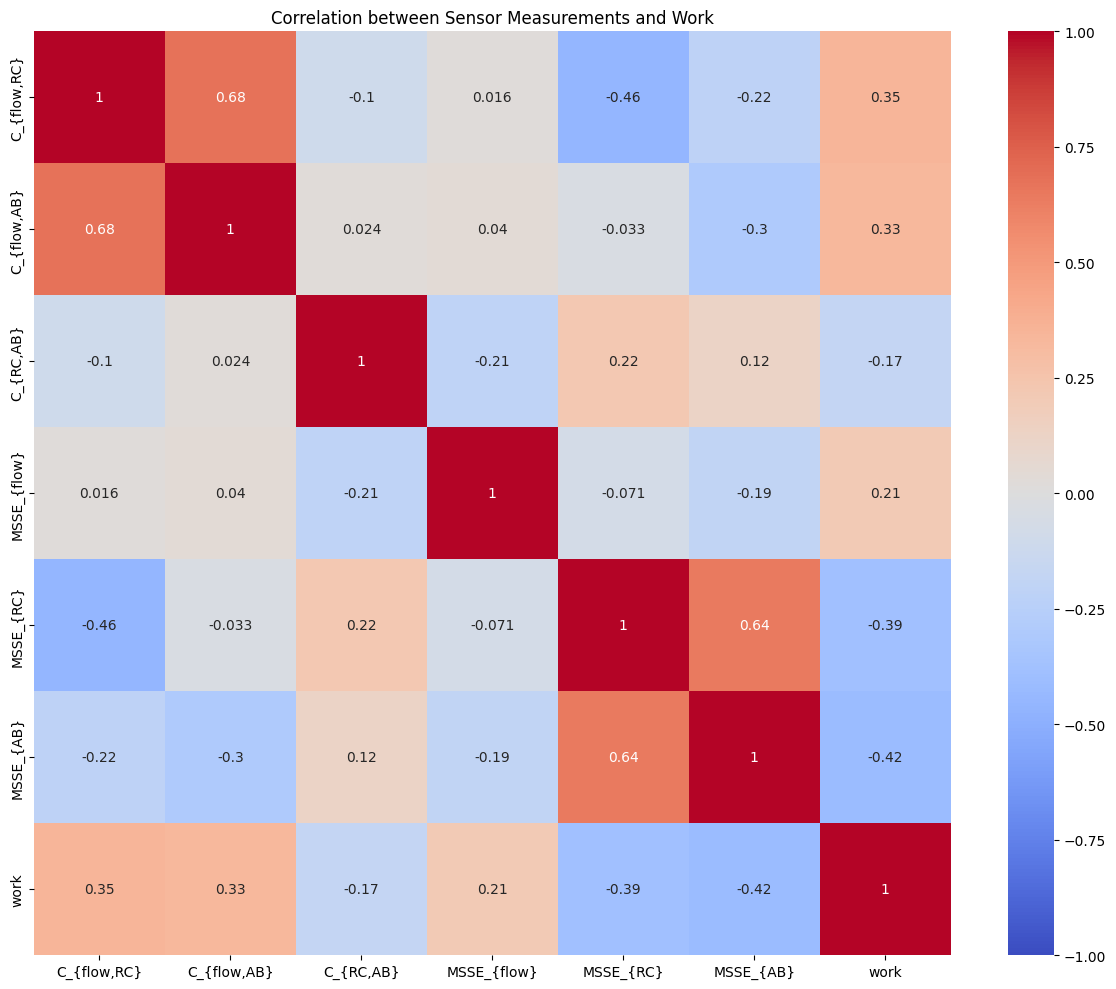

Mean values for sensor measurements and work across load conditions:
                   C_{flow,RC}  C_{flow,AB}  C_{RC,AB}  MSSE_{flow}  \
Load_Condition                                                        
High load (CST)       0.437748     0.172739   0.841476     0.459689   
High load (PVT)       0.511067     0.227049   0.837061     0.470281   
Medium Load (CST)     0.505160     0.313035   0.820972     0.418561   
Medium Load (PVT)     0.469125     0.286971   0.849986     0.507622   
No load (CST)         0.258565     0.131491   0.940820     0.311925   
No load (PVT)         0.277016     0.162234   0.936647     0.302954   

                   MSSE_{RC}  MSSE_{AB}      work  
Load_Condition                                     
High load (CST)     0.894457   1.361804  7.908818  
High load (PVT)     0.828654   1.333039  9.369881  
Medium Load (CST)   0.859693   1.247913  9.368621  
Medium Load (PVT)   0.935314   1.236023  9.626537  
No load (CST)       1.420440   1.690101  3.420604 

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a mapping for load conditions
load_mapping = {
    1: 'No load (CST)',
    2: 'No load (PVT)',
    3: 'Medium Load (CST)',
    4: 'Medium Load (PVT)',
    5: 'High load (CST)',
    6: 'High load (PVT)'
}

df['Load_Condition'] = df['Label'].map(load_mapping)

# Select relevant features for sensor measurements and performance
sensor_features = ['C_{flow,RC}', 'C_{flow,AB}', 'C_{RC,AB}', 'MSSE_{flow}', 'MSSE_{RC}', 'MSSE_{AB}']
performance_feature = 'work'  # We'll use 'work' as a proxy for performance

# Create a correlation matrix
correlation_matrix = df[sensor_features + [performance_feature]].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Sensor Measurements and Work')
plt.tight_layout()
plt.show()

# Calculate mean values for sensor measurements across load conditions
mean_values = df.groupby('Load_Condition')[sensor_features + [performance_feature]].mean()
print("Mean values for sensor measurements and work across load conditions:")
print(mean_values)

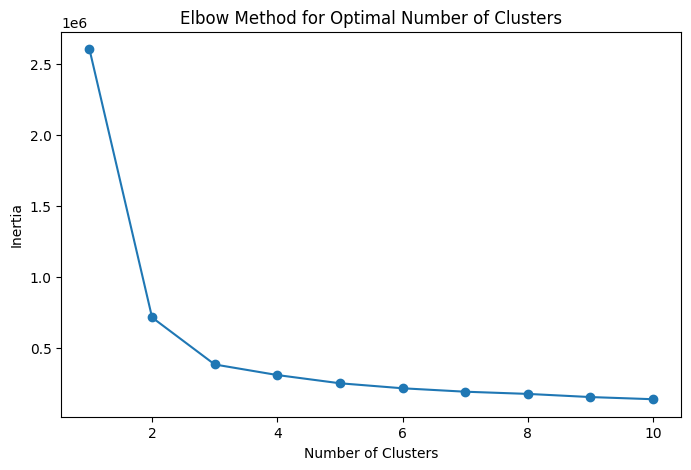

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform cluster analysis on the dataset to identify different compensation strategies
# We'll use the features related to compensation strategies for clustering
compensation_features = ['Volume', 'T_i', '% RCi', 'work', 'PTP', 'workPerLiter']
X_compensation = df[compensation_features].values

# Determine the optimal number of clusters using the elbow method
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_compensation)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Cluster Means:
           Volume       T_i     % RCi       work        PTP  workPerLiter
Cluster                                                                  
0        0.568814  1.401176  0.315434   3.054678   7.132298      5.605269
1        1.370791  2.708131  0.341543  11.220433  20.253895      8.457306
2        0.619972  1.608260  0.324255  15.435667  34.178039     24.920551


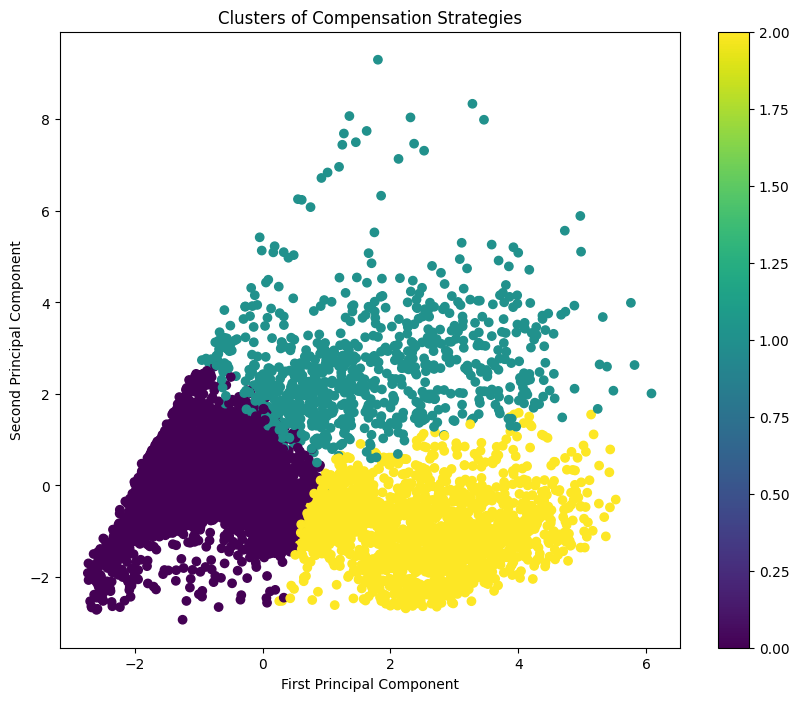

Number of samples in each cluster:
Cluster
0    6015
2    1838
1     815
Name: count, dtype: int64


In [43]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the features
scaler = StandardScaler()
X_compensation_scaled = scaler.fit_transform(X_compensation)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_compensation_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

# Analyze cluster characteristics
cluster_means = df.groupby('Cluster')[compensation_features].mean()
print("Cluster Means:")
print(cluster_means)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_compensation_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters of Compensation Strategies')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# Print the number of samples in each cluster
print("\
Number of samples in each cluster:")
print(df['Cluster'].value_counts())

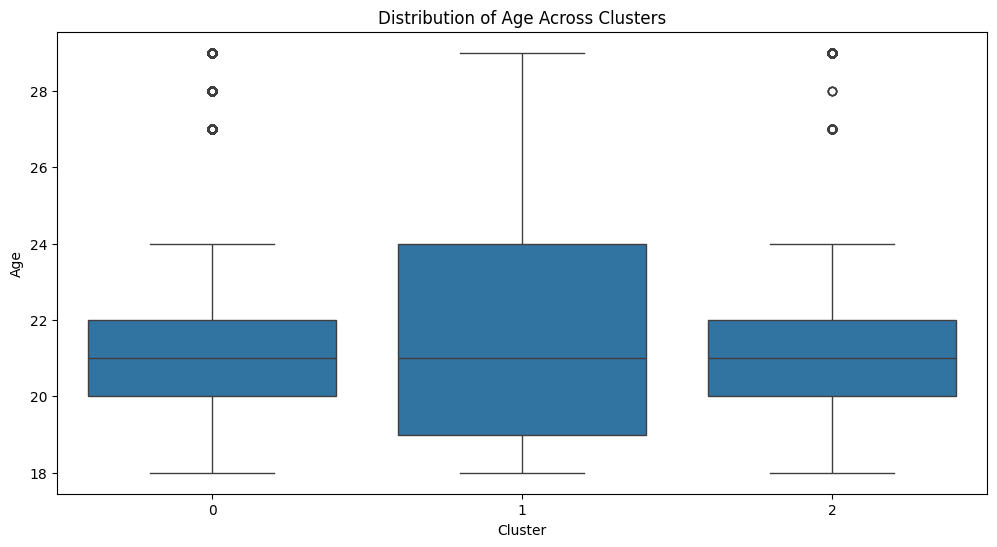

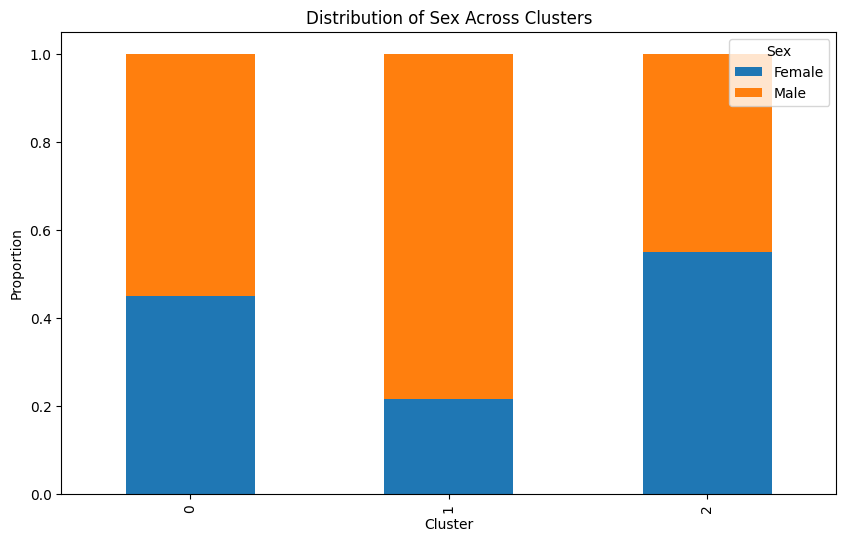

ANOVA test for age differences between clusters:
F-statistic: 11.675825129601726, p-value: 8.631256059304115e-06
Chi-square test for sex distribution across clusters:
Chi-square statistic: 255.0823865957732, p-value: 4.069710675308761e-56
Cluster Summary:
               Age  Proportion_Male
Cluster                            
0        21.601829         0.549626
1        21.850307         0.785276
2        21.949402         0.451034


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Analyze the impact of age on compensation
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title('Distribution of Age Across Clusters')
plt.show()

# Analyze the impact of sex on compensation
sex_cluster_crosstab = pd.crosstab(df['Cluster'], df['Sex'])
sex_cluster_crosstab_norm = sex_cluster_crosstab.div(sex_cluster_crosstab.sum(axis=1), axis=0)
sex_cluster_crosstab_norm.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Sex Across Clusters')
plt.ylabel('Proportion')
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.show()

# Perform statistical tests
print("ANOVA test for age differences between clusters:")
f_statistic, p_value = stats.f_oneway(df[df['Cluster'] == 0]['Age'],
                                      df[df['Cluster'] == 1]['Age'],
                                      df[df['Cluster'] == 2]['Age'])
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

print("\
Chi-square test for sex distribution across clusters:")
chi2, p_value, dof, expected = stats.chi2_contingency(sex_cluster_crosstab)
print(f"Chi-square statistic: {chi2}, p-value: {p_value}")

# Calculate mean age and sex distribution for each cluster
cluster_summary = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Sex': lambda x: (x == 1).mean()  # Assuming 1 represents male
}).rename(columns={'Sex': 'Proportion_Male'})

print("\
Cluster Summary:")
print(cluster_summary)

In [46]:
import pandas as pd

# Define personalized training programs based on cluster characteristics
training_programs = {
    0: {
        "name": "Balanced Endurance Program",
        "focus": "Improve overall respiratory endurance",
        "exercises": [
            "Diaphragmatic breathing exercises",
            "Moderate-intensity aerobic training",
            "Inspiratory muscle training at 50% of maximal inspiratory pressure"
        ],
        "frequency": "3-4 times per week",
        "duration": "30-45 minutes per session"
    },
    1: {
        "name": "High-Volume Respiratory Program",
        "focus": "Enhance respiratory muscle strength and endurance",
        "exercises": [
            "High-volume breathing exercises",
            "Interval training with respiratory challenges",
            "Inspiratory muscle training at 60-70% of maximal inspiratory pressure"
        ],
        "frequency": "4-5 times per week",
        "duration": "45-60 minutes per session"
    },
    2: {
        "name": "Power Breathing Program",
        "focus": "Develop respiratory power and efficiency",
        "exercises": [
            "Power breathing techniques",
            "High-intensity interval training",
            "Inspiratory muscle training at 70-80% of maximal inspiratory pressure"
        ],
        "frequency": "3-4 times per week",
        "duration": "30-45 minutes per session"
    }
}

# Create a DataFrame from the training programs
training_df = pd.DataFrame.from_dict(training_programs, orient='index')

# Add cluster characteristics to the DataFrame
training_df['Mean Age'] = cluster_summary['Age']
training_df['Proportion Male'] = cluster_summary['Proportion_Male']

# Display the personalized training programs
print("Personalized Respiratory Training Programs:")
print(training_df)

# Calculate and display the distribution of participants across clusters
cluster_distribution = df['Cluster'].value_counts(normalize=True) * 100
print("\
Distribution of Participants Across Clusters:")
print(cluster_distribution)

Personalized Respiratory Training Programs:
                              name  \
0       Balanced Endurance Program   
1  High-Volume Respiratory Program   
2          Power Breathing Program   

                                               focus  \
0              Improve overall respiratory endurance   
1  Enhance respiratory muscle strength and endurance   
2           Develop respiratory power and efficiency   

                                           exercises           frequency  \
0  [Diaphragmatic breathing exercises, Moderate-i...  3-4 times per week   
1  [High-volume breathing exercises, Interval tra...  4-5 times per week   
2  [Power breathing techniques, High-intensity in...  3-4 times per week   

                    duration   Mean Age  Proportion Male  
0  30-45 minutes per session  21.601829         0.549626  
1  45-60 minutes per session  21.850307         0.785276  
2  30-45 minutes per session  21.949402         0.451034  
Distribution of Participants Across C